In [71]:
import numpy as np
from scipy.sparse import diags, dia_matrix
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs, eigsh

In [72]:
# Initial parameters

hbar = 1
h = 2*np.pi*hbar
e = 1
flux_quantum = h / (2*e)

phi_max = np.pi
phi_min = -phi_max

N = 100
delta = 2*phi_max / (N - 1)

In [73]:
# Identity matrix
I = diags([1], [0], shape=(N, N))

# Define the elementwise cosine of the (reduced) phase operator in the phase basis.
# Notice that the interval [-pi, pi] is defined for the reduced flux 

diagonals_phi = np.cos(np.linspace(phi_min, phi_max, N))
phi = diags(diagonals_phi, 0)
cos_phi = phi

# Define the (reduced) charge operator. Being the derivative of the reduced phase, 
# we simply define the reduced charge operator using the finite difference method

data = np.array([-np.ones(N),np.zeros(N),np.ones(N)])
offsets = np.array([-1, 0, 1])
n = - 1j/(2*delta) * dia_matrix((data, offsets), shape=(N, N)).tolil() #tolil() for inserting values
n[N - 1, 0] = - 1j/(2*delta)
n[0, N - 1] = 1j/(2*delta)

# Define the square of the reduced charge operator

data = np.array([np.ones(N),-2*np.ones(N),np.ones(N)])
n2 = - 1/(delta**2) * dia_matrix((data, offsets), shape=(N, N)).tolil()
n2[N - 1, 0] = -1/(delta**2)
n2[0, N - 1] = -1/(delta**2)


In [74]:
# Function which returns the transmon Hamiltonian. Notice how the kinetic term has been expanded using [n, I] = 0

def hamiltonian_phi(EC, EJ, ng, phi_ext, d, n, cos_phi):
    H_C = 4*EC*(n2 + ng**2*I - 2*ng*I @ n)
    H_J = -EJ * (np.cos(phi_ext)**2 + d**2 * np.sin(phi_ext)**2) * cos_phi
    return H_C + H_J

In [75]:
# Solve the Hamiltonian

EC = 0.3
EJ1 = 7.5
EJ2 = 7.5
EJ_tot = EJ1 + EJ2  
ng = 0
phi_ext = 0
d = 0

number_of_eigenvalues = 7

H_phi = hamiltonian_phi(EC, EJ_tot, ng, phi_ext, d, n, cos_phi)
vals, vecs = eigsh(H_phi, k=number_of_eigenvalues, which='SR')

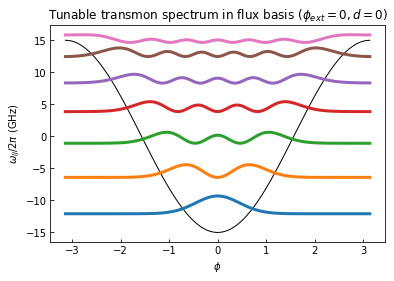

In [76]:
#plt.figure(figsize=(6, 4))

xvals = np.linspace(phi_min, phi_max, N)
plt.plot(xvals, -EJ_tot*np.sqrt(np.cos(phi_ext)**2 + d**2*np.sin(phi_ext)**2)*np.cos(xvals), color='black', linewidth=1)

for i in range(number_of_eigenvalues):
    plt.plot(xvals, 50*np.abs(vecs[:, i])**2 + np.real(vals[i]), linewidth=3)

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega_{ij}/2\pi$ (GHz)')
plt.tick_params(axis='both', direction='in')
plt.title(r'Tunable transmon spectrum in flux basis ($\phi_{ext} = 0, d = 0$)')

plt.savefig('transmon_spectrum_flux_basis.jpg', dpi=300)

plt.show()

In [77]:
# For later use, we save the ground state wavefunction in the phase basis

groundstate_phi = vecs[:,0]

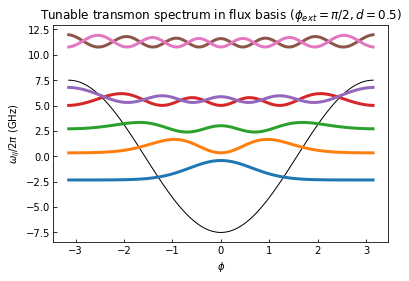

In [78]:
phi_ext = np.pi/2
d = 0.5

H_phi_2 = hamiltonian_phi(EC, EJ_tot, ng, phi_ext, d, n, cos_phi)
vals2, vecs2 = eigsh(H_phi_2, k=number_of_eigenvalues, which='SR')

#plt.figure(figsize=(6, 4))

xvals = np.linspace(phi_min, phi_max, N)
plt.plot(xvals, -EJ_tot*np.sqrt(np.cos(phi_ext)**2 + d**2*np.sin(phi_ext)**2)*np.cos(xvals), color='black', linewidth=1)

for i in range(number_of_eigenvalues):
    plt.plot(xvals, 50*np.abs(vecs2[:, i])**2 + np.real(vals2[i]), linewidth=3)

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega_{ij}/2\pi$ (GHz)')
plt.tick_params(axis='both', direction='in')
plt.title(r'Tunable transmon spectrum in flux basis ($\phi_{ext} = \pi/2, d = 0.5$)')

plt.savefig('transmon_spectrum_flux_basis_tuned.jpg', dpi=300)

plt.show()

# Week 3 E2 is put here 

In [79]:
# Now, let's repeat the excersise in the charge basis. Here, the charge operator is diagonal

phi_ext = 0
d = 0
n_cutoff = 5
diagonals_n = np.arange(2*n_cutoff + 1) - n_cutoff
n = diags(diagonals_n, 0)

# Identity matrix
I = diags([1], [0], shape=(2*n_cutoff + 1, 2*n_cutoff + 1))

# The cosine of the reduced phase operator in the charge basis is implemented using eqs. (16) and (18) from https://arxiv.org/pdf/2106.05342
ones = 1/2*np.ones(2*n_cutoff + 1)
data = np.array([ones, ones])
offsets = np.array([-1, 1])
cos_phi = dia_matrix((data, offsets), shape=(2*n_cutoff + 1, 2*n_cutoff + 1))

In [80]:
# Define the Hamiltonian
# Notice again the expansion of the kinetic term

def hamiltonian_n(EC, EJ, ng, phi_ext, d, n, cos_phi):
    H = 4*EC*(n @ n + ng**2*I - 2*ng*I @ n) - EJ*np.sqrt(np.cos(phi_ext)**2 + d**2*np.sin(phi_ext)**2)*cos_phi
    return H

In [81]:
# We solve for the eigenvalues and -vectors, now in the charge basis

H_n = hamiltonian_n(EC, EJ_tot, ng, phi_ext, d, n, cos_phi)

vals, vecs = eigs(H_n, k=number_of_eigenvalues, which='SR')

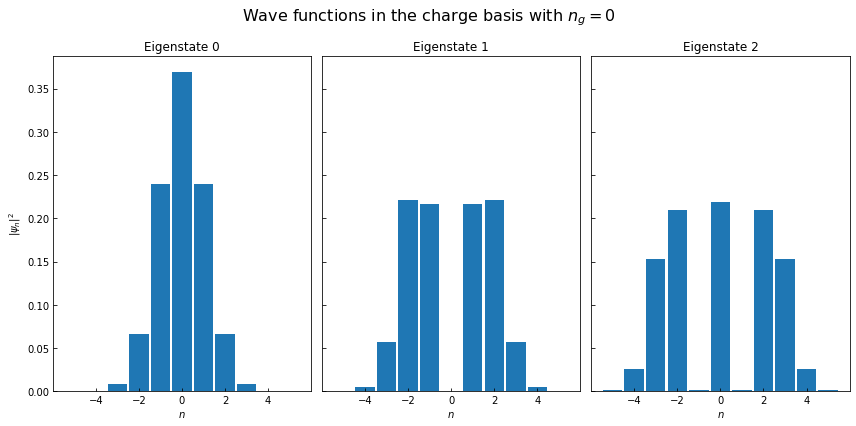

In [82]:
fig, axs = plt.subplots(1,3, figsize=(12,6), sharey=True, tight_layout=True)

xvals = np.arange(2*n_cutoff + 1) - n_cutoff
for i in range(3):
    axs[i].bar(xvals, np.abs(vecs[:, i])**2, label=f'Eigenstate {i}', width=0.9)
    axs[i].set_xlabel(r'$n$')
    axs[i].set_title(f'Eigenstate {i}')
    axs[i].tick_params(axis='both', direction='in')
    
axs[0].set_ylabel(r'$|\psi_n|^2$')
fig.suptitle(r'Wave functions in the charge basis with $n_g = 0$', fontsize=16)
plt.savefig('transmon_wavefunctions_charge_basis.jpg', dpi=300)
plt.show()

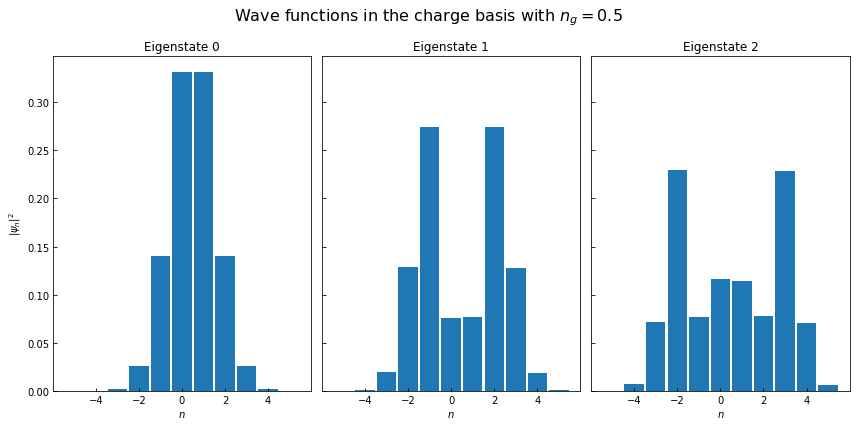

In [83]:
# We can try to change the charge offset ng to see how the eigenstates change

H_n2 = hamiltonian_n(EC, EJ_tot, 0.5, phi_ext, d, n, cos_phi)

vals, vecs = eigs(H_n2, k=number_of_eigenvalues, which='SR')
fig, axs = plt.subplots(1,3, figsize=(12,6), sharey=True, tight_layout=True)

xvals = np.arange(2*n_cutoff + 1) - n_cutoff
for i in range(3):
    axs[i].bar(xvals, np.abs(vecs[:, i])**2, label=f'Eigenstate {i}', width=0.9)
    axs[i].set_xlabel(r'$n$')
    axs[i].set_title(f'Eigenstate {i}')
    axs[i].tick_params(axis='both', direction='in')

axs[0].set_ylabel(r'$|\psi_n|^2$')
fig.suptitle(r'Wave functions in the charge basis with $n_g = 0.5$', fontsize=16)

plt.savefig('transmon_wavefunctions_charge_basis_ng.jpg', dpi=300)
plt.show()

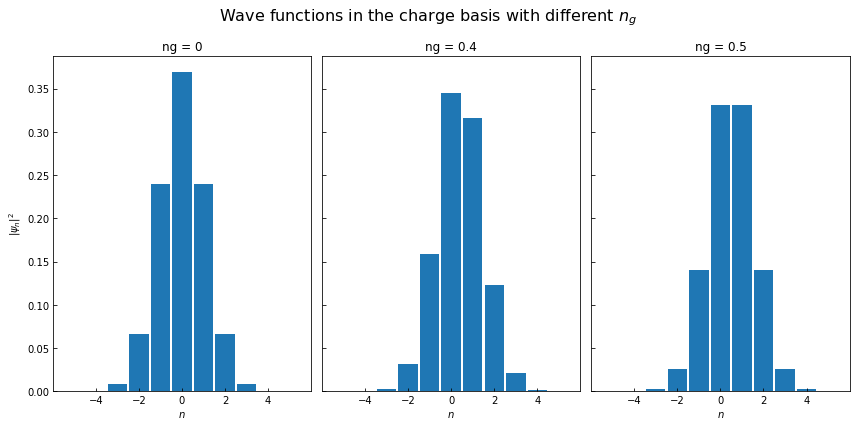

In [84]:
ng_values = [0, 0.4, 0.5]  # Values of ng

fig, axs = plt.subplots(1,3, figsize=(12,6), sharey=True, tight_layout=True)

xvals = np.arange(2*n_cutoff + 1) - n_cutoff

for i in range(3):
    H_n2 = hamiltonian_n(EC, EJ_tot, ng_values[i], phi_ext, d, n, cos_phi)
    vals2, vecs2 = eigs(H_n2, k=1, which='SR')
    axs[i].bar(xvals, np.abs(vecs2[:, 0])**2, label=f'ng = {ng_values[i]}', width=0.9)
    axs[i].set_xlabel(r'$n$')
    axs[i].set_title(f'ng = {ng_values[i]}')
    axs[i].tick_params(axis='both', direction='in')

axs[0].set_ylabel(r'$|\psi_n|^2$')
fig.suptitle(r'Wave functions in the charge basis with different $n_g$', fontsize=16)

plt.savefig('transmon_wavefunctions_charge_basis_ng2.jpg', dpi=300)

plt.show()

In [85]:
# This is the expected behaviour. We see that for ng = 0, the energy is minimized when the charge is zero, and for ng = 0.5, 
# since the wavefunction can take on integer values only, it spreads evenly around n = 0.5. For ng = 0.4, the wavefunction 
# is slightly closer to 0 than 1 to minimize the energy.

# We can transform the eigenstates back into the phase basis via the transformation matrix
# with matrix elements <n_i|phi_j> = 1/sqrt(d) exp(- i/hbar n_i phi_j)

# Define the transformation matrix
d = N
T = np.zeros((N, 2*n_cutoff + 1), dtype=complex)
for j in range(2*n_cutoff + 1):
    for i in range(N):
        T[i, j] = 1/np.sqrt(d) * np.exp(-1j * (j - n_cutoff) * (i*delta - np.pi))

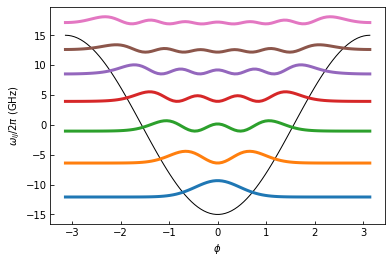

In [86]:
# We plot the eigenstates as obtained by transformation to the phase basis. 
# The eigenvalues should not depend on the choice of basis

xvals = np.linspace(phi_min, phi_max, N)
plt.plot(xvals, -EJ_tot*np.sqrt(np.cos(phi_ext)**2 + d**2*np.sin(phi_ext)**2)*np.cos(xvals), label='Potential', color='black', linewidth=1)
for i in range(number_of_eigenvalues):
    vec = T @ vecs[:, i]
    plt.plot(xvals, 50*np.abs(vec)**2 + np.real(vals[i]), label=f'Eigenstate {i}', linewidth=3)

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega_{ij}/2\pi$ (GHz)')
plt.tick_params(axis='both', direction='in')
plt.show()

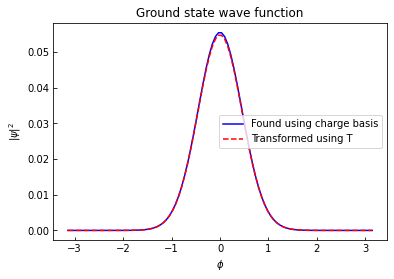

In [87]:
# We can verify the correctness of the transformation by comparing the newly found ground state in the phase 
# basis with the one obtained directly in the first excersise

groundstate_phi2 = T @ vecs[:,0]

plt.plot(xvals, np.abs(groundstate_phi)**2, '-', color = 'blue')
plt.plot(xvals, np.abs(groundstate_phi2)**2, '--', color='red')

plt.tick_params(axis='both', direction='in')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$|\psi|^2$')
plt.legend(['Found using charge basis', 'Transformed using T'])
plt.title('Ground state wave function')
plt.show()